In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
X.columns

Index(['year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet',
       'sclact', 'gndr', 'agea', 'CH', 'CZ', 'DE', 'ES', 'NO', 'SE'],
      dtype='object')

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [4]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
print(table_train)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All'] # false-positive
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All'] # false-negative

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


col_0     0.0   1.0   All
partner                  
0.0      4167   341  4508
1.0      1291  1533  2824
All      5458  1874  7332
Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

[1.96155330e-03 2.18737219e-02 1.02130794e-02 1.22691960e-02
 8.87972320e-03 1.19038603e-01 3.02876152e-02 9.97741726e-03
 3.69044623e-02 7.21434773e-01 2.54943268e-03 3.84443804e-03
 5.24250181e-04 1.46544261e-02 4.00682703e-03 1.58048166e-03]


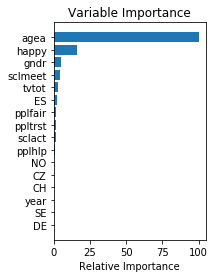

In [5]:
feature_importance = clf.feature_importances_
print(feature_importance)

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [6]:
# Let's try adding some more features
df['age_sq'] = df['agea'] * df['agea']
df['happy_sq'] = df['happy'] * df['happy']
df['age+happy'] = df['agea'] + df['happy']
df.head(5)

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,age_sq,happy_sq,age+happy
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,3600.0,64.0,68.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,3481.0,81.0,68.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,576.0,49.0,31.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,4096.0,100.0,74.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,3025.0,64.0,63.0


In [7]:
# redefine X since we added columns
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [8]:
X.columns

Index(['year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet',
       'sclact', 'gndr', 'agea', 'age_sq', 'happy_sq', 'age+happy', 'CH', 'CZ',
       'DE', 'ES', 'NO', 'SE'],
      dtype='object')

In [9]:
# Let's turn this into a function so that we don't have to keep repeating this large block of code    
def get_errors(parameters):
    
    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**parameters)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All'] # false-positive
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All'] # false-negative

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
    
    return clf
   
get_errors(params)

Training set accuracy:
Percent Type I errors: 0.044053464266230226
Percent Type II errors: 0.176759410801964

Test set accuracy:
Percent Type I errors: 0.06134969325153374
Percent Type II errors: 0.19631901840490798


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

[1.96155330e-03 2.18737219e-02 1.02130794e-02 1.22691960e-02
 8.87972320e-03 1.19038603e-01 3.02876152e-02 9.97741726e-03
 3.69044623e-02 7.21434773e-01 2.54943268e-03 3.84443804e-03
 5.24250181e-04 1.46544261e-02 4.00682703e-03 1.58048166e-03]


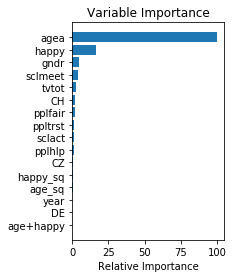

In [10]:
feature_importance = clf.feature_importances_
print(feature_importance)

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The new features, as it turns out, isn't very important. Let's try a few more different features.

In [11]:
# First drop ineffective new columns
df = df.drop(['age_sq', 'happy_sq', 'age+happy'], axis=1)
df.columns

Index(['cntry', 'idno', 'year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp',
       'happy', 'sclmeet', 'sclact', 'gndr', 'agea', 'partner'],
      dtype='object')

In [12]:
# Add new columns
df['agea*gndr'] = df['agea'] * df['gndr']
df['agea*happy'] = df['agea'] * df['happy']
df['sclmeet*tvtot'] = df['sclmeet'] * df['tvtot']
df.columns

Index(['cntry', 'idno', 'year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp',
       'happy', 'sclmeet', 'sclact', 'gndr', 'agea', 'partner', 'agea*gndr',
       'agea*happy', 'sclmeet*tvtot'],
      dtype='object')

In [18]:
# redefine X since we added columns
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [19]:
get_errors(params)

Training set accuracy:
Percent Type I errors: 0.014184397163120567
Percent Type II errors: 0.10092744135297327

Test set accuracy:
Percent Type I errors: 0.11533742331288344
Percent Type II errors: 0.14478527607361963


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

[1.96155330e-03 2.18737219e-02 1.02130794e-02 1.22691960e-02
 8.87972320e-03 1.19038603e-01 3.02876152e-02 9.97741726e-03
 3.69044623e-02 7.21434773e-01 2.54943268e-03 3.84443804e-03
 5.24250181e-04 1.46544261e-02 4.00682703e-03 1.58048166e-03]


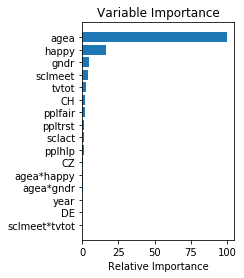

In [20]:
feature_importance = clf.feature_importances_
print(feature_importance)

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [21]:
# Let's make 1000 iterations 
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

get_errors(params)

Training set accuracy:
Percent Type I errors: 0.04159847244953628
Percent Type II errors: 0.16189307146753956

Test set accuracy:
Percent Type I errors: 0.0736196319018405
Percent Type II errors: 0.17668711656441718


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Decreased training errors but increased test errors. It does make sense that more iterations will cause overfitting of the training data. So let's tune the model in different ways.

In [23]:
# How does changing the max_depth affect our model?
params = {'n_estimators': 1000,
          'max_depth': 5,
          'loss': 'deviance'}

get_errors(params)

Training set accuracy:
Percent Type I errors: 0.00013638843426077467
Percent Type II errors: 0.007774140752864157

Test set accuracy:
Percent Type I errors: 0.1325153374233129
Percent Type II errors: 0.1668711656441718


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [25]:
# Let's experiment
params = {'n_estimators': 1000,
          'max_depth': 5,
          'loss': 'exponential'}

get_errors(params)

Training set accuracy:
Percent Type I errors: 0.0004091653027823241
Percent Type II errors: 0.010638297872340425

Test set accuracy:
Percent Type I errors: 0.12515337423312883
Percent Type II errors: 0.16441717791411042


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
# Let's see if subsampling will bring down the overfitting
params = {'n_estimators': 500,
          'max_depth': 5,
          'loss': 'deviance',
          'subsample': 0.9}

get_errors(params)

Training set accuracy:
Percent Type I errors: 0.0032733224222585926
Percent Type II errors: 0.037506819421713036

Test set accuracy:
Percent Type I errors: 0.10429447852760736
Percent Type II errors: 0.16809815950920245


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.9, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)